In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seed = 123909783

In [2]:
df_nav830 = pd.read_csv("ML_Project_tbl_nav830_hist_1yr.csv")
df_arch = pd.read_csv("ML_Project_ldos_archive_1yr.csv")
df_znmps = pd.read_csv("ML_Project_tbl_znmps3400_1yr.csv")

In [3]:
df_arch['updated_ts'] = pd.to_datetime(df_arch['updated_ts'])
df_arch['updated'] = df_arch['updated_ts'].dt.normalize() # Get rid of time component

df_nav830['updated'] = pd.to_datetime(df_nav830['updated'])
df_nav830['company'] = df_nav830['ncmp']

In [4]:
df_nav830

,updated,qualifier,bano,item,cono,cont,supplier_alias,csel,schn,seqn,...,wk08,wk09,wk10,wk11,wk12,flx,mth4,mth5,mth6,company
0,2023-03-26,HDR,20230326015582,4122569F91,AM537A,3120,ghejd,X5,571541,0,...,16.0,18.0,17.0,20.0,14.0,44.0,197.0,112.0,114.0,65
1,2023-03-26,HDR,20230326004672,4030197C1,AB480A,2595,abiga,X1,570387,0,...,0.0,0.0,50.0,0.0,0.0,50.0,50.0,0.0,50.0,65
2,2023-03-26,HDR,20230326004929,425FTA1125,034ECA,2760,aefjc,X1,559955,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,65
3,2023-03-26,HDR,20230326008435,450RTH1685,053EAA,2335,bdhfe,X2,574317,0,...,4.0,0.0,18.0,19.0,5.0,40.0,131.0,107.0,98.0,65
4,2023-03-26,HDR,20230326010466,4368389C1,AI589A,3205,djiba,X4,560643,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921129,2022-10-30,HDR,20221030016821,7782685703,026MYA,2817,hieff,X1,686864,0,...,4.0,0.0,22.0,20.0,0.0,21.0,59.0,14.0,138.0,65
921130,2022-10-30,HDR,20221030016822,3660382C1,AZ041A,524,higbd,X1,673403,0,...,10.0,0.0,10.0,70.0,10.0,30.0,40.0,0.0,0.0,65
921131,2022-10-30,HDR,20221030016828,3840495C2,AZ041A,524,higbd,X1,680989,0,...,15.0,0.0,20.0,10.0,35.0,40.0,60.0,70.0,35.0,65
921132,2022-10-30,HDR,20221030016833,3813372C1,AZ041A,524,higbd,X1,687127,0,...,0.0,0.0,50.0,50.0,0.0,50.0,50.0,100.0,50.0,65


In [5]:
df = df_nav830.sort_values(by='updated',ascending=False)

In [6]:
df.groupby('item')

In [7]:
# Calculate Percentage Change between last week's prediction and this week's prediction
# df['prev_wk02'] = df.groupby('item')['wk02'].shift(-1)
for i in range(2, 13):
    df[f'prev_wk{i:02d}'] = df.groupby('item')[f'wk{i:02d}'].shift(-1)
    df[f'pc_wk{i-1:02d}'] = (df[f'wk{i-1:02d}'] - df[f'prev_wk{i:02d}']) / df[f'prev_wk{i:02d}'].replace(0, np.nan)
    df[f'pc_wk{i-1:02d}'] = df[f'pc_wk{i-1:02d}'].fillna(0)
    df[f'pc_wk{i-1:02d}'] = df[f'pc_wk{i-1:02d}'].clip(upper=1,lower=-1) # Ensure values are in a range

In [8]:
# Check Function
# df.loc[df['item']=='4122569F91',['updated','pc_wk01','wk01','prev_wk02','pc_wk02','wk02','prev_wk03','wk03']]
# We will want to dropna() here; these will be the records with nothing to compare with

In [9]:
pc_week_cols = [f'pc_wk{str(i).zfill(2)}' for i in range(1, 12)] # up to pc_wk11
schedule_data = df[pc_week_cols]

In [10]:
scaler = StandardScaler()
schedule_scaled = pd.DataFrame(scaler.fit_transform(schedule_data), columns=pc_week_cols)

In [11]:
from sklearn.decomposition import PCA



In [12]:
# Choose the number of components, for example, 2
pca = PCA(n_components=2)
pca_data = pca.fit_transform(schedule_data)

In [13]:
from sklearn.cluster import KMeans

# Choose the number of clusters you want, for example, 3
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_data)
clusters = kmeans.labels_

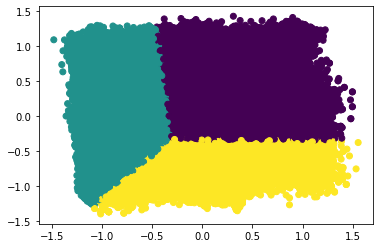

In [14]:
import matplotlib.pyplot as plt

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.show()

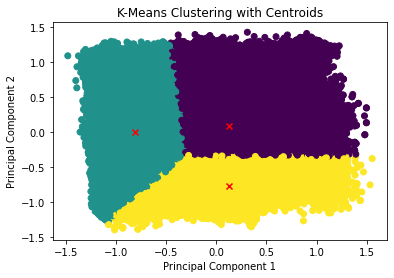

In [15]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.title('K-Means Clustering with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [16]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(schedule_data)

In [21]:
explained_variance = pca.explained_variance_ratio_
for i, exp_var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {exp_var * 100:.2f}% of the variance")

Principal Component 1: 13.92% of the variance
Principal Component 2: 11.21% of the variance
Principal Component 3: 10.66% of the variance


IndexError: index 2 is out of bounds for axis 1 with size 2

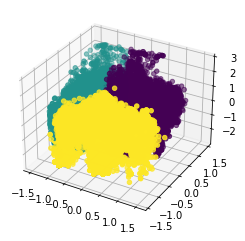

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clusters, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', marker='x')
plt.title('K-Means Clustering with Centroids')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


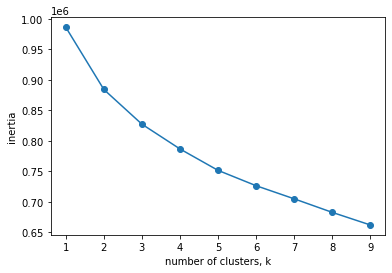

In [26]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model= KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(schedule_data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [27]:
# Print the explained variance ratio
explained_variance = pca.explained_variance_ratio_
for i, exp_var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {exp_var * 100:.2f}% of the variance")

Principal Component 1: 13.92% of the variance
Principal Component 2: 11.21% of the variance


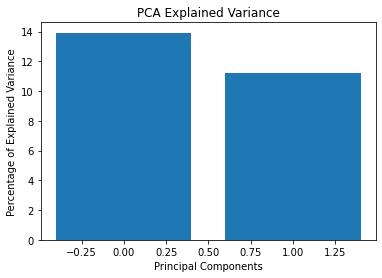

In [28]:


plt.bar(range(len(explained_variance)), explained_variance * 100)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('PCA Explained Variance')
plt.show()